# <font  color = "#B00000">SLEEPY Benchmark</font>

The following notebook is for comparing SLEEPY performance among different systems. We run each simulation with and without parallel usage to determine additionally where parallel processing improves behavior. Plotting is not counted in computational time.

In [1]:
# SETUP SLEEPY
import os
os.chdir('../../../')

In [2]:
import SLEEPY as sl
from time import time
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import subprocess
import sys

## Versions

In [4]:
print(f'Python: {sys.version.split(" (")[0]}')
print(f'Numpy: {np.version.version}')
print(f'Scipy: {sp.version.version}')
try:
    result = subprocess.run(['pip','show','multiprocess'], stdout=subprocess.PIPE)
    vs=result.stdout.decode().split('Version: ')[1].split('Summary')[0].strip()
    print(f'Multiprocess: {vs}')
except:
    print('Multiprocess is not installed (recommended)')
if hasattr(np.__config__,'blas_mkl_info') and 'mkl_rt' in np.__config__.blas_mkl_info['libraries']:
    print('Uses Intel MKL')
else:
    print('Intel MKL not in use (recommended)')

Python: 3.11.13
Numpy: 1.24.3
Scipy: 1.10.1
Multiprocess: 0.70.15
Uses Intel MKL


## Benchmark 1: $R_{1\rho}$ relaxation

State-space reduction: 32->16
Series time: 210 ms
Propagators calculated: 1470, Propagators from cache: 0
State-space reduction: 32->16
Parallel time: 242 ms
Propagators calculated: 1285, Propagators from cache: 0


<Axes: xlabel='t / ms', ylabel='<$^{15}N_x$>'>

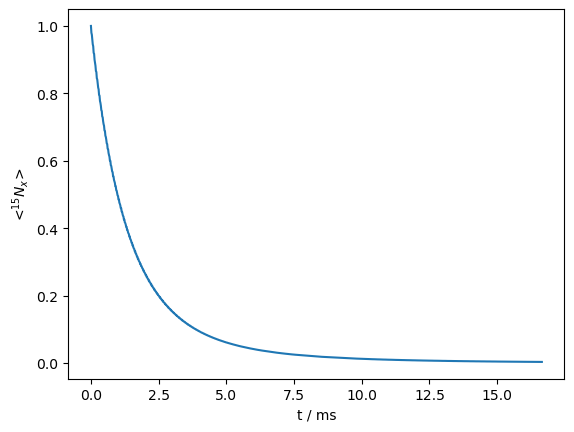

In [3]:
sl.Defaults['cache']=True
for parallel in [False,True]:
    sl.Defaults['parallel']=parallel
    t0=time()
    ex0=sl.ExpSys(600,Nucs=['15N','1H'],vr=60000,pwdavg=2,n_gamma=30)
    ex0.set_inter('dipole',i0=0,i1=1,delta=22000)
    ex0.set_inter('CSA',i=0,delta=110,euler=[0,15,0])
    ex1=ex0.copy()
    ex0.set_inter('dipole',i0=0,i1=1,delta=22000,euler=[0,30,0])
    ex0.set_inter('CSA',i=0,delta=110,euler=[[0,15,0],[0,30,0]])
    
    L=sl.Liouvillian(ex0,ex1,kex=sl.Tools.twoSite_kex(1e-6))
    seq=L.Sequence().add_channel('15N',v1=35000)
    rho=sl.Rho(rho0='15Nx',detect='15Nx')
    rho,seq=rho.ReducedSetup(seq)
    rho.DetProp(seq,n=1000)
    print(f'{"Parallel" if parallel else "Series"} time: {(time()-t0)*1e3:.0f} ms')
    print(f'Propagators calculated: {rho.L._PropCache.cache_count[0]}, Propagators from cache: {rho.L._PropCache.cache_count[1]}')
rho.plot()

## Benchmark 2: REDOR

In [4]:
sl.Defaults['cache']=True
for parallel in [False,True]:
    sl.Defaults['parallel']=parallel    
    t0=time()
    ex0=sl.ExpSys(v0H=600,Nucs=['15N','1H'],vr=60000,pwdavg=sl.PowderAvg('bcr20'),n_gamma=30)
    # After varying the powder average and n_gamma
    # a beta-average and 30 gamma angles were determined to be sufficient
    delta=sl.Tools.dipole_coupling(.102,'15N','1H')
    phi=35*np.pi/180

    ex0.set_inter('dipole',i0=0,i1=1,delta=delta)
    L=sl.Tools.Setup3siteSym(ex0,tc=1e-9,phi=phi)
    
    v1=120e3 #100 kHz pulse
    tp=1/v1/2 #pi/2 pulse length

    t=[0,L.taur/2-tp,L.taur/2,L.taur-tp,L.taur]
    first=L.Sequence().add_channel('1H',t=t,v1=[0,v1,0,v1],phase=[0,0,0,np.pi/2,0])
    t=[0,tp,L.taur/2,L.taur/2+tp,L.taur]
    second=L.Sequence().add_channel('1H',t=t,v1=[v1,0,v1,0],phase=[np.pi/2,0,0,0,0])
    center=L.Sequence().add_channel('15N',t=[0,L.taur/2-tp/2,L.taur/2+tp/2,L.taur],
                                   v1=[0,v1,0])

    Ucenter=center.U()
    Ufirst=first.U()
    Usecond=second.U()

    rho=sl.Rho('15Nx','15Nx')
    U1=L.Ueye()
    U2=L.Ueye()


    for k in range(48):
        rho.reset()
        (U2*Ucenter*U1*rho)()
        U1=Ufirst*U1
        U2=Usecond*U2
    print(f'{"Parallel" if parallel else "Series"} time: {(time()-t0):.1f} s')
    print(f'Propagators calculated: {L._PropCache.cache_count[0]}, Propagators from cache: {L._PropCache.cache_count[1]}')

Series time: 16.7 s
Propagators calculated: 13800, Propagators from cache: 45000
Parallel time: 25.8 s
Propagators calculated: 13791, Propagators from cache: 43582


<Axes: xlabel='t / ms', ylabel='<$^{15}N_x$>'>

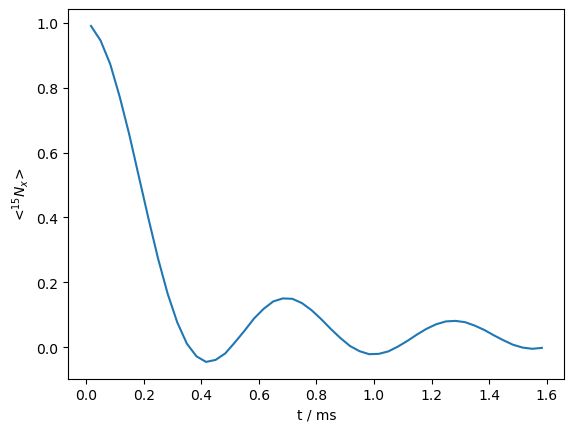

In [21]:
rho.plot()

## Benchmark 3: Pseudocontact shift under MAS

In [ ]:
sl.Defaults['cache']=True
for parallel in [False,True]:
    sl.Defaults['cache']=True
    sl.Defaults['parallel']=parallel
    t0=time()
    delta=sl.Tools.dipole_coupling(1,'e-','13C')    #10 Angstroms from electron
    ex=sl.ExpSys(v0H=600,Nucs=['13C','e-'],vr=6000,LF=True,T_K=200,pwdavg=6,n_gamma=30)  #Electron-nuclear system
    ex.set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta)
    ex.set_inter('g',i=1,gxx=1,gyy=1,gzz=4)
    
    L=sl.Liouvillian(ex)        #Generate a Liouvillian
    
    L.add_relax('T1',i=1,T1=2e-8,OS=True,Thermal=True)  
    L.add_relax('T2',i=1,T2=2e-8,OS=True)
    
    seq=L.Sequence() #Generate an empty sequence
    
    rho200=sl.Rho('13Cx','13Cp')  #Generate initial state, detection operator
    _=rho200.DetProp(seq,n=8000,n_per_seq=1) #Propagate the system
    
    rho200.downmix()
    
    
    print(f'{"Parallel" if parallel else "Series"} time: {(time()-t0):.1f} s')
    print(f'Propagators calculated: {L._PropCache.cache_count[0]}, Propagators from cache: {L._PropCache.cache_count[1]}')
    L._PropCache.cache_count[:]=0

    t0=time()
    rho200.clear().DetProp(seq,n=8000,n_per_seq=1).downmix()
    print(f'{"Parallel" if parallel else "Series"} time after caching: {(time()-t0):.1f} s')
    print(f'Propagators calculated: {L._PropCache.cache_count[0]}, Propagators from cache: {L._PropCache.cache_count[1]}')

Series time: 17.3 s
Propagators calculated: 8970, Propagators from cache: 0
Series time after caching: 1.8 s
Propagators calculated: 0, Propagators from cache: 8970


Exception ignored in: <function PropCache.__del__ at 0x117e839c0>
Traceback (most recent call last):
  File "/Users/albertsmith/Documents/GitHub/SLEEPY/SLEEPY/Propagator.py", line 718, in __del__
    sm.unlink()
  File "/opt/miniconda3/lib/python3.11/site-packages/multiprocess/shared_memory.py", line 243, in unlink
    _posixshmem.shm_unlink(self._name)
FileNotFoundError: [Errno 2] No such file or directory: '/psm_c52f9aca'
Exception ignored in: <function PropCache.__del__ at 0x117e839c0>
Traceback (most recent call last):
  File "/Users/albertsmith/Documents/GitHub/SLEEPY/SLEEPY/Propagator.py", line 718, in __del__
    sm.unlink()
  File "/opt/miniconda3/lib/python3.11/site-packages/multiprocess/shared_memory.py", line 243, in unlink
    _posixshmem.shm_unlink(self._name)
FileNotFoundError: [Errno 2] No such file or directory: '/psm_c52f9aca'
Exception ignored in: <function PropCache.__del__ at 0x117e839c0>
Traceback (most recent call last):
  File "/Users/albertsmith/Documents/GitHub

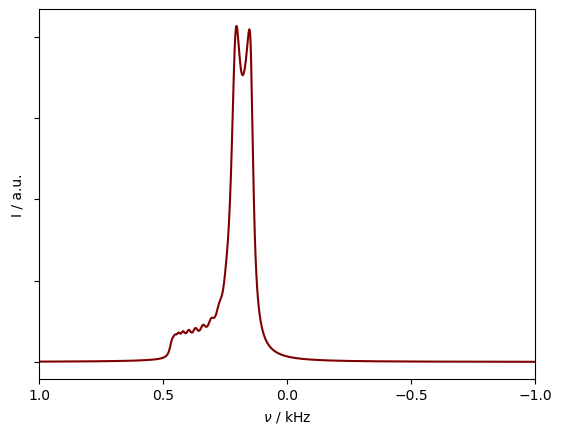

In [6]:
ax=rho200.plot(FT=True,color='maroon') #Plot the results into the same axis
ax.set_xlim([1,-.5])
ax.set_yticklabels('')
_=ax.set_xticks([-1,-.5,0,.5,1])

## Benchmark 4: Water hopping (4/5/6-spin simulation)

In [7]:
n=3 #Number of 1H (number of spins is n+1)
sl.Defaults['cache']=True
for parallel in [False,True]:
    sl.Defaults['parallel']=parallel
    t0=time()

    # CH couplings
    delta=np.array([4606.92351485, 1797.74007351, 3013.38969601, 1109.64922884,
       2016.55071255,  985.46533497])
    beta=np.array([1.52269289, 1.32442461, 1.72911212, 2.00710785, 0.79886871,
       2.50129217])
    gamma=np.array([ 0.90747836,  1.24462096, -1.94198315, -2.26840075, -0.28942014,
       -0.97775707])

    # HH couplings
    deltaHH=np.array([[240240.30545617,  61146.36447292,   1970.3813349 ,
          1155.61145146,   6094.10132617,   1985.91135194],
       [ 61146.36447292, 240240.30545617,   1794.04721071,
          1006.48333044,   5846.61932559,   2152.90241365],
       [  1970.3813349 ,   1794.04721071, 240240.30545617,
         61145.15653655,   2294.80686596,   7166.863992  ],
       [  1155.61145146,   1006.48333044,  61145.15653655,
        240240.30545617,   2580.00271199,   6890.73630547],
       [  6094.10132617,   5846.61932559,   2294.80686596,
          2580.00271199, 240240.30545617,  61343.71356863],
       [  1985.91135194,   2152.90241365,   7166.863992  ,
          6890.73630547,  61343.71356863, 240240.30545617]])
    betaHH=np.array([[1.57079633, 2.42558372, 1.29852807, 1.13067005, 2.41964498, 2.4303553 ],
       [0.71600894, 1.57079633, 1.05488134, 0.9288108 , 1.97712181, 2.13051745],
       [1.84306458, 2.08671132, 1.57079633, 0.71601651, 0.67347314, 0.68760657],
       [2.0109226 , 2.21278185, 2.42557615, 1.57079633, 0.98826407, 1.16112572],
       [0.72194768, 1.16447084, 2.46811952, 2.15332858, 1.57079633, 2.42864234],
       [0.71123735, 1.01107521, 2.45398609, 1.98046694, 0.71295032, 1.57079633]])
    gammaHH=np.array([[ 0.00000000e+00, -1.04923238e+00,  1.05757029e+00,
8.88208378e-01,  1.51992907e+00,  1.40024175e+00],
       [ 2.09236028e+00,  0.00000000e+00, -1.14726745e+00,
        -9.56226609e-01,  1.69785967e+00,  1.56297278e+00],
       [-2.08402236e+00,  1.99432521e+00,  0.00000000e+00,
        -2.04361472e-03, -2.43231532e+00, -2.64270770e+00],
       [-2.25338428e+00,  2.18536604e+00,  3.13954904e+00,
         0.00000000e+00, -2.61192428e+00, -2.80947505e+00],
       [-1.62166358e+00, -1.44373298e+00,  7.09277331e-01,
         5.29668373e-01,  0.00000000e+00,  1.13672151e+00],
       [-1.74135091e+00, -1.57861987e+00,  4.98884952e-01,
         3.32117606e-01, -2.00487114e+00,  0.00000000e+00]])

    # 13C CSA
    deltaCSA=15.983465288047174
    etaCSA=-0.10233422812456781
    alphaCSA=-1.1674898472001762
    betaCSA=0.914512792179852
    gammaCSA=-1.312316331380307

    # 1H CS/CSA
    HCS=np.array([22.99922011, 24.97644825, 24.97644846, 22.99921996, 24.52192647, 23.98644806])

    deltaHCSA=np.array([17.60332199, 15.80323671, 15.97227992, 18.56681946, 16.48042676, 16.77075626])
    etaHCSA=np.array([-0.10418638, -0.10503486, -0.08225994, -0.14162113, -0.18843222, -0.11487855])
    alphaHCSA=np.array([-2.12485296, -2.14137643,  0.91297352, -0.55202972,  2.27784746, -0.91270437])
    betaHCSA=np.array([0.93737428, 2.23403156, 2.228757  , 2.17804567, 2.26820148, 0.96358604])
    gammaHCSA=np.array([ 1.25827576, -0.2144375 , -2.31668105,  2.28178711,  0.17926152, -1.23977268])

    ex=sl.ExpSys(v0H=400,Nucs=['13C',*['1H' for _ in range(n)]],vr=5000,pwdavg=sl.PowderAvg(q=2))
    ex.set_inter('CSA',i=0,delta=deltaCSA,eta=etaCSA,euler=[alphaCSA,betaCSA,gammaCSA])
    for k in range(n):
        ex.set_inter('dipole',i0=0,i1=k+1,delta=delta[k],euler=[0,beta[k],gamma[k]])
        ex.set_inter('CSA',i=k+1,delta=deltaHCSA[k],euler=[alphaHCSA[k],betaHCSA[k],gammaHCSA[k]])
        ex.set_inter('CS',i=k+1,ppm=HCS[k])
        for m in range(k+1,n):
            ex.set_inter('dipole',i0=k+1,i1=m+1,delta=deltaHH[k,m],euler=[0,betaHH[k,m],gammaHH[k,m]])

    L=ex.Liouvillian()

    L.add_SpinEx(i=[1,2],tc=1e-4)
    if n>3:
        L.add_SpinEx(i=[3,4],tc=1e-4)
    print(f'{(time()-t0):.1f}')
    for i in range(n):
        L.add_relax(Type='SpinDiffusion',i=i+1,k=0)
    print(f'{(time()-t0):.1f}')
    seq=L.Sequence().add_channel('13C',v1=22000)

    rho=sl.Rho(rho0='13Cx',detect='13Cx')
    rho,seq=rho.ReducedSetup(seq)
    rho.DetProp(seq,n=500)

    print(f'{"Parallel" if parallel else "Series"} time: {(time()-t0):.1f} s')
    print(f'Propagators calculated: {rho.L._PropCache.cache_count[0]}, Propagators from cache: {rho.L._PropCache.cache_count[1]}')
    rho.L._PropCache.cache_count[:]=0
    t0=time()
    rho.DetProp(seq,n=500)
    print(f'{"Parallel" if parallel else "Series"} time after caching: {(time()-t0):.1f} s')
    print(f'Propagators calculated: {rho.L._PropCache.cache_count[0]}, Propagators from cache: {rho.L._PropCache.cache_count[1]}')

0.1
0.1
State-space reduction: 256->80
Series time: 3.8 s
Propagators calculated: 4900, Propagators from cache: 0
Series time after caching: 0.7 s
Propagators calculated: 0, Propagators from cache: 4900
0.0
0.1
State-space reduction: 256->80
Parallel time: 4.4 s
Propagators calculated: 4778, Propagators from cache: 0
Parallel time after caching: 1.0 s
Propagators calculated: 0, Propagators from cache: 4260


<Axes: xlabel='t / ms', ylabel='<$^{13}C_x$>'>

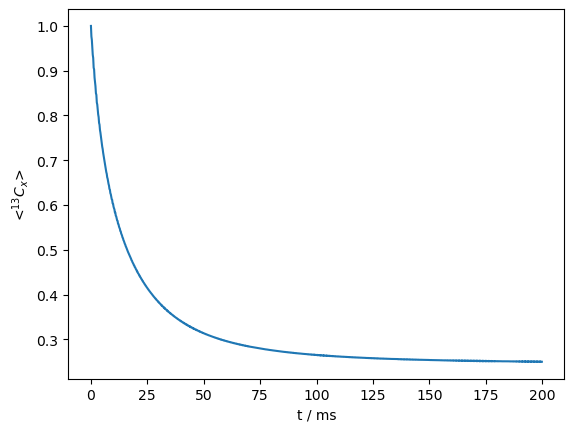

In [8]:
rho.plot()